In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Split according to distribution

df = pd.read_csv("data\LIACC\cpu_small_data.csv", ",")
df= df.fillna(0)

# Calculate Correlation between coloumns 
corr_values = []
highest_corr = 0
highest_col = 0

for col in df:
    corr = df["usr"].corr(df[col])
    corr_values.append(corr)
    if corr >= max(corr_values) and corr < 1.0:
        highest_corr = corr
        highest_col = col
    #print("Correlation between the target and "+ str(col) + " : " + str(corr))
    #print(highest_corr)

# Selecto Corr >= 0,4 and sort data accordingly 
print ("Column: "+str(highest_col)+ " has the highest correlation with the target: " + str(highest_corr))
df = df.sort_values(by=[highest_col], ascending = False)
df = df.reset_index(drop=True)

# Split df in 3 equal parts
split = int(len(df[:1000])/3)
df_1 = df.loc[0:split,:]
df_2 = df.loc[split:split*2,:]
df_3 = df.loc[split*2:split*3,:]
print("Df has been split into 3 equal parts: ",df_1.shape,df_2.shape,df_3.shape)

Column: freeswap has the highest correlation with the target: 0.6785262417399928
Df has been split into 3 equal parts:  (334, 13) (334, 13) (334, 13)


In [3]:
df_src = df_2 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_3
#print(df_tar.head(), df_tar.shape)

In [4]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

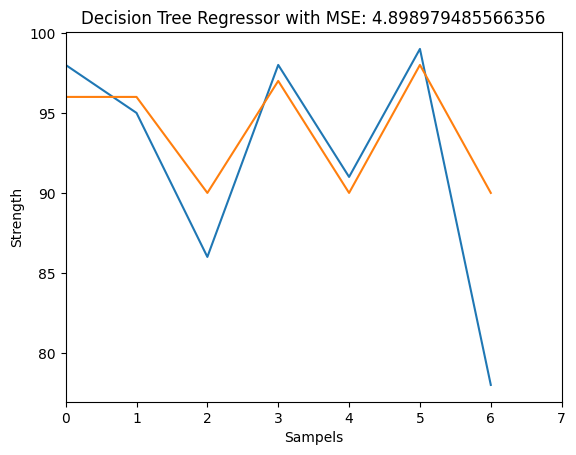

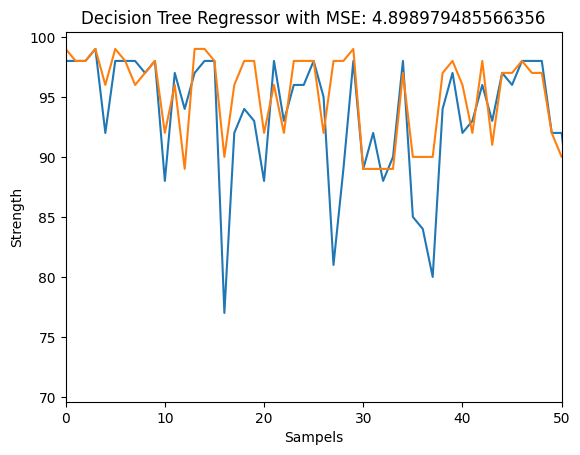

MSE Baseline Testdata:  4.977021099511215
MSE Baseline Validationdata:  5.427005178626434


In [12]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    
    clf = DecisionTreeRegressor(max_depth=5)
    clf.fit(X_train, y_train)

    y_pre_ridge = clf.predict(X_test)
    mse_ridge = np.sqrt( sklearn.metrics.mean_squared_error(y_test, y_pre_ridge) )
    results_transfer.append(mse_ridge)

    y_pre_ridge_val = clf.predict(Xt[25:])
    mse_ridge_val = np.sqrt( sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge_val) )
    results_transfer_val.append(mse_ridge_val)

plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(X_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

plt.plot(Yt[25:].reset_index(drop=True))
plt.plot(y_pre_ridge_val)
plt.xlim(0, 50)
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

In [7]:
def kernel(ker, X1, X2, gamma):
    K = None
    if ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1), np.asarray(X2))
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1))
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1), np.asarray(X2), gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1), None, gamma)
    return K

class KMM:
    def __init__(self, kernel_type='linear', gamma=1.0, B=1.0, eps=None):
        '''
        Initialization function
        :param kernel_type: 'linear' | 'rbf'
        :param gamma: kernel bandwidth for rbf kernel
        :param B: bound for beta
        :param eps: bound for sigma_beta
        '''
        self.kernel_type = kernel_type
        self.gamma = gamma
        self.B = B
        self.eps = eps

    def fit(self, Xs, Xt):
        '''
        Fit source and target using KMM (compute the coefficients)
        :param Xs: ns * dim
        :param Xt: nt * dim
        :return: Coefficients (Pt / Ps) value vector (Beta in the paper)
        '''
        ns = Xs.shape[0]
        nt = Xt.shape[0]
        if self.eps == None:
            self.eps = self.B / np.sqrt(ns)
        K = kernel(self.kernel_type, Xs, None, self.gamma)
        kappa = np.sum(kernel(self.kernel_type, Xs, Xt, self.gamma) * float(ns) / float(nt), axis=1)

        K = matrix(K.astype(np.double))
        kappa = matrix(kappa.astype(np.double))
        G = matrix(np.r_[np.ones((1, ns)), -np.ones((1, ns)), np.eye(ns), -np.eye(ns)])
        h = matrix(np.r_[ns * (1 + self.eps), ns * (self.eps - 1), self.B * np.ones((ns,)), np.zeros((ns,))])

        sol = solvers.qp(K, -kappa, G, h, kktsolver='ldl', options={'kktreg':1e-9})
        beta = np.array(sol['x'])
        return beta

In [35]:
import plotly.express as px
from sklearn.decomposition import PCA
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

sub_src_df_1 = ['df_2', 'df_3', 'df_1', 'df_3', 'df_1', 'df_2']
sub_tar_df_2 = ['df_1', 'df_1', 'df_2', 'df_2', 'df_3', 'df_3']

for i in range (2,3):

    df_src = getattr(modobj, sub_src_df_1[i])

    df_tar = getattr(modobj, sub_tar_df_2[i])

    # source split
    Xs = df_src.iloc[:,:-1]
    Ys = df_src.iloc[:,-1]

    # target split
    Xt = df_tar.iloc[:,:-1]
    Yt = df_tar.iloc[:,-1]


    results_transfer = []
    results_transfer_val = []

    kmm_1 = KMM() #kernel_mean_matching(Xs, Xt[:25], kern='rbf', B=10) # kmm(Xs, Xt[:25], sigma=10) 
    beta = kmm_1.fit(Xs, Xt[:25])

    Xs_new = beta * Xs

    model =  DecisionTreeRegressor(max_depth=5) #KNeighborsRegressor(n_neighbors=3) #linear_model.Lasso(alpha=15) #DecisionTreeRegressor(max_depth=5)
    model.fit(Xs_new, Ys )
    y_pre_kmm = model.predict(Xt[:25])
    mse_kmm = np.sqrt( mean_squared_error(Yt[:25], y_pre_kmm) )
    results_transfer.append(mse_kmm)

    y_pre_ridge = model.predict(Xt[25:])
    mse_kmm_val = np.sqrt( sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge) )
    results_transfer_val.append(mse_kmm_val)

    print("MSE Transfer Testdata: ", np.mean(results_transfer))
    print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

    Xs['beta'] = beta
    Xs['beta_T_F'] = 1
    Xt['beta_T_F'] = 2
    Xt['beta'] = 2
    Xs = Xs.append(Xt[:25])

    pca = PCA(n_components=3)
    components = pca.fit_transform(Xs.iloc[:,:-1])

    total_var = pca.explained_variance_ratio_.sum() * 100

    fig = px.scatter_3d(
        components, x=0, y=1, z=2, color=Xs['beta'], symbol=Xs['beta_T_F'], color_continuous_scale="Bluered_r", #range_color=(np.mean(beta)-np.mean(beta)*0.02,np.mean(beta)+np.mean(beta)*0.02),
        title=f'Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
    )
    fig.update_traces(marker_size = 5)
    fig.show()

pcost       dcost       gap    pres   dres
 0: -1.9689e+17 -1.9689e+17  9e+04  3e-01  1e-16
 1: -1.9689e+17 -1.9689e+17  5e+04  2e-01  1e-16
 2: -1.9689e+17 -1.9689e+17  5e+04  1e-01  1e-16
 3: -1.9689e+17 -1.9689e+17  5e+04  1e-01  1e-16
 4: -1.9689e+17 -1.9689e+17  7e+04  1e-01  1e-16
 5: -1.9689e+17 -1.9689e+17  9e+04  1e-01  1e-16
 6: -1.9689e+17 -1.9689e+17  1e+05  1e-01  1e-16
 7: -1.9689e+17 -1.9689e+17  1e+05  1e-01  1e-16
 8: -1.9689e+17 -1.9689e+17  2e+05  1e-01  1e-16
 9: -1.9689e+17 -1.9689e+17  2e+05  1e-01  1e-16
10: -1.9689e+17 -1.9689e+17  2e+05  1e-01  1e-16
11: -1.9689e+17 -1.9689e+17  2e+05  1e-01  1e-16
12: -1.9689e+17 -1.9689e+17  3e+05  1e-01  1e-16
13: -1.9689e+17 -1.9689e+17  3e+05  1e-01  1e-16
14: -1.9689e+17 -1.9689e+17  4e+05  1e-01  1e-16
15: -1.9689e+17 -1.9689e+17  4e+05  1e-01  1e-16
16: -1.9689e+17 -1.9689e+17  5e+05  1e-01  1e-16
17: -1.9689e+17 -1.9689e+17  7e+05  1e-01  1e-16
18: -1.9689e+17 -1.9689e+17  8e+05  1e-01  1e-16
19: -1.9689e+17 -1.9689e+1

In [36]:
    fig = px.scatter_3d(
        components, x=0, y=1, z=2, symbol=Xs['beta_T_F'], color_continuous_scale="Bluered_r", #range_color=(np.mean(beta)-np.mean(beta)*0.02,np.mean(beta)+np.mean(beta)*0.02),
        title=f'Total Explained Variance: {total_var:.2f}%',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
    )
    fig.update_traces(marker_size = 
    12)
    fig.show()

In [14]:
import os
import sys
import numpy as np 
import math
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import math, numpy, sklearn.metrics.pairwise as sk

In [11]:
# an implementation of Kernel Mean Matchin
# referenres:
#  1. Gretton, Arthur, et al. "Covariate shift by kernel mean matching." Dataset shift in machine learning 3.4 (2009): 5.
#  2. Huang, Jiayuan, et al. "Correcting sample selection bias by unlabeled data." Advances in neural information processing systems. 2006.
def kernel_mean_matching(X, Z, kern='lin', B=1.0, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B/math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    print("Rank K", matrix_rank(K))
    kappa = matrix(kappa)
    print("Rank kappa", matrix_rank(kappa))
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    print("Rank G", matrix_rank(G))
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    print("Rank h", matrix_rank(h))
    
    sol = solvers.qp(K, -kappa, G, h, kktsolver='ldl', options={'kktreg':1e-9})
    coef = np.array(sol['x'])
    print("Hi")
    return coef

def kmm(Xtrain, Xtest, sigma):
    n_tr = len(Xtrain)
    n_te = len(Xtest)

    # calculate Kernel
    print('Computing kernel for training data ...')
    K_ns = sk.rbf_kernel(Xtrain, Xtrain, sigma)
    # make it symmetric
    K = 0.9 * (K_ns + K_ns.transpose())

    # calculate kappa
    print('Computing kernel for kappa ...')
    kappa_r = sk.rbf_kernel(Xtrain, Xtest, sigma)
    ones = numpy.ones(shape=(n_te, 1))
    kappa = numpy.dot(kappa_r, ones)
    kappa = -(float(n_tr) / float(n_te)) * kappa

    # calculate eps
    eps = (math.sqrt(n_tr) - 1) / math.sqrt(n_tr)

    # constraints
    A0 = numpy.ones(shape=(1, n_tr))
    A1 = -numpy.ones(shape=(1, n_tr))
    A = numpy.vstack([A0, A1, -numpy.eye(n_tr), numpy.eye(n_tr)])
    b = numpy.array([[n_tr * (eps + 1), n_tr * (eps - 1)]])
    b = numpy.vstack([b.T, -numpy.zeros(shape=(n_tr, 1)), numpy.ones(shape=(n_tr, 1)) * 1000])

    print('Solving quadratic program for beta ...')
    P = matrix(K, tc='d')
    q = matrix(kappa, tc='d')
    G = matrix(A, tc='d')
    h = matrix(b, tc='d')
    beta = solvers.qp(P, q, G, h, kktsolver='ldl', options={'kktreg':1e-9})
    return [i for i in beta['x']]

def compute_rbf(X, Z, sigma=1.0):
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i,:] = np.exp(-np.sum((vx-Z)**2, axis=1)/(2.0*sigma))
    return K

In [12]:
x = 11*np.random.random(100)- 6.0
y = x**2 + 10*np.random.random(100) - 5
Z = np.c_[x, y]

x = 2*np.random.random(10) - 6.0
y = x**2 + 10*np.random.random(10) - 5
X = np.c_[x, y]

#coef = kernel_mean_matching(df_2, df_1, kern='rbf', B=10)
coef = kmm(Z, X, sigma=10)

plt.close()
plt.figure()
plt.scatter(Z[:,0], Z[:,1], color='black', marker='x')
plt.scatter(X[:,0], X[:,1], color='red')
plt.scatter(Z[:,0], Z[:,1], color='green', s=np.asarray(coef)*100, alpha=0.5)

#np.sum(np.asarray(coef) > 1e-2)

Computing kernel for training data ...


NameError: name 'sk' is not defined

In [ ]:
import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define MMD

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

sub_src_df_1 = ['df_2', 'df_3', 'df_1', 'df_3', 'df_1', 'df_2']
sub_tar_df_2 = ['df_1', 'df_1', 'df_2', 'df_2', 'df_3', 'df_3']

mmd = []

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU
    return device
    
# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

for i in range (0,6):

    df_src = getattr(modobj, sub_src_df_1[i])

    df_tar = getattr(modobj, sub_tar_df_2[i])

    df_src_tensor = df_to_tensor(df_src)
    df_tar_tensor = df_to_tensor(df_tar)

    result = MMD(df_src_tensor, df_tar_tensor, kernel="multiscale")

    mmd.append(result.item())

    print(f"MMD result of {sub_src_df_1[i]} and {sub_tar_df_2[i]} is {result.item()}")

In [61]:
mmd

[0.024310674518346786,
 0.024167247116565704,
 0.024310674518346786,
 0.024095529690384865,
 0.024167247116565704,
 0.024095531553030014]